# 03 - Bivariate Analysis

In [1]:
# All import insertions
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import isnull
from sklearn import preprocessing
import os    # For file paths
import re    # Regular Expressions

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Open files
df = pd.read_csv("../data/processed/data_univ.csv", low_memory=False)

In [3]:
df.dtypes.value_counts()

int64      41
object     13
float64     7
dtype: int64

In [4]:
df = df.loc[:, (df.dtypes == np.int32) | (df.dtypes == np.float32) | (df.dtypes == np.int64) | (df.dtypes == np.float64)]

<Figure size 3600x2592 with 0 Axes>

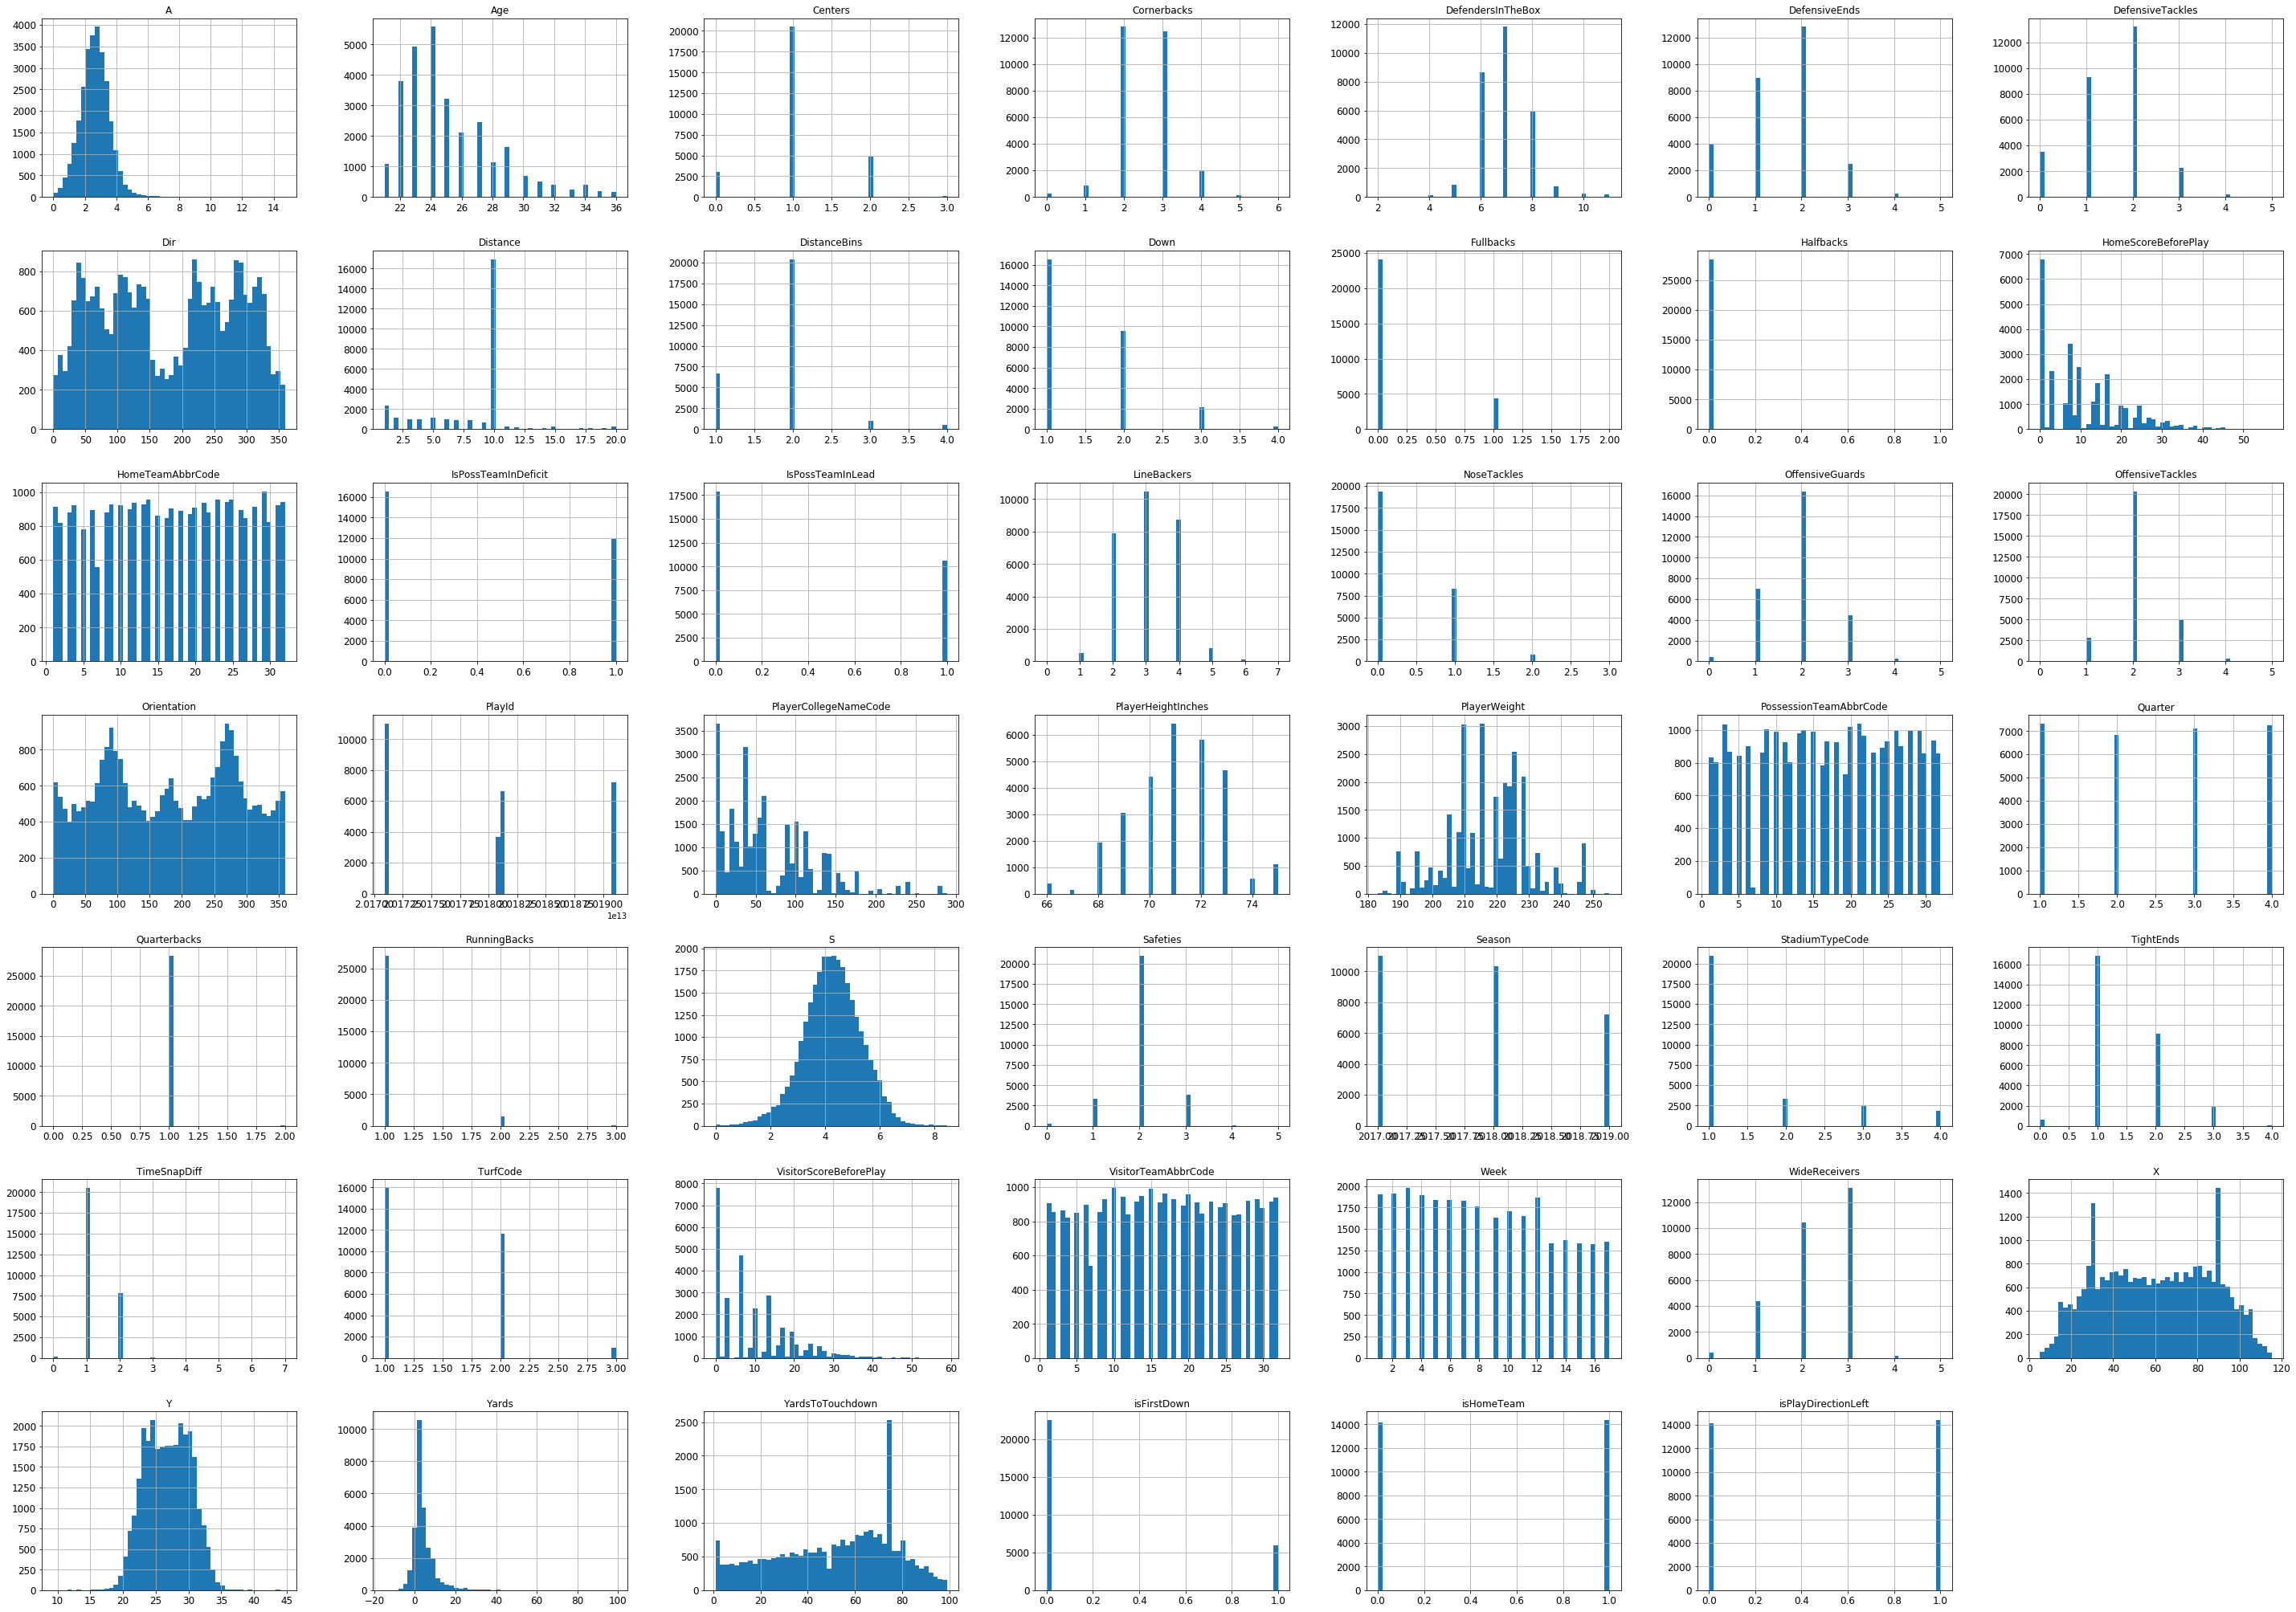

In [5]:
plt.figure(figsize=(50,36))
df.hist(figsize=(50,36), bins=50, xlabelsize=12, ylabelsize=12)
plt.savefig("../reports/figures/data_allhist.png")

In [6]:
df.var().sort_values()

Halfbacks                 7.014590e-05
Quarterbacks              4.818317e-03
RunningBacks              5.152131e-02
Fullbacks                 1.324680e-01
isFirstDown               1.657367e-01
TimeSnapDiff              2.113528e-01
IsPossTeamInLead          2.335694e-01
IsPossTeamInDeficit       2.434469e-01
isPlayDirectionLeft       2.499816e-01
isHomeTeam                2.499924e-01
Centers                   2.863769e-01
NoseTackles               2.897930e-01
Safeties                  2.958499e-01
DistanceBins              3.060172e-01
TurfCode                  3.151856e-01
OffensiveTackles          3.240585e-01
TightEnds                 4.246339e-01
Down                      4.487152e-01
OffensiveGuards           4.887744e-01
Cornerbacks               5.376614e-01
WideReceivers             6.168220e-01
Season                    6.207760e-01
DefensiveTackles          7.048649e-01
DefensiveEnds             7.611988e-01
LineBackers               8.009593e-01
StadiumTypeCode          

In [7]:
df.drop(['Quarterbacks','Halfbacks','RunningBacks','Fullbacks'], axis=1, inplace=True)

In [8]:
#Correlation with output variable
cor = df.corr()

#Correlation with output variable
cor_target = abs(cor["isFirstDown"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Yards          0.520142
isFirstDown    1.000000
Name: isFirstDown, dtype: float64

In [9]:
# Yards is the only fields that has a high correlation with the new predictor variable, can be removed
df.drop(['Yards'], axis=1, inplace=True)

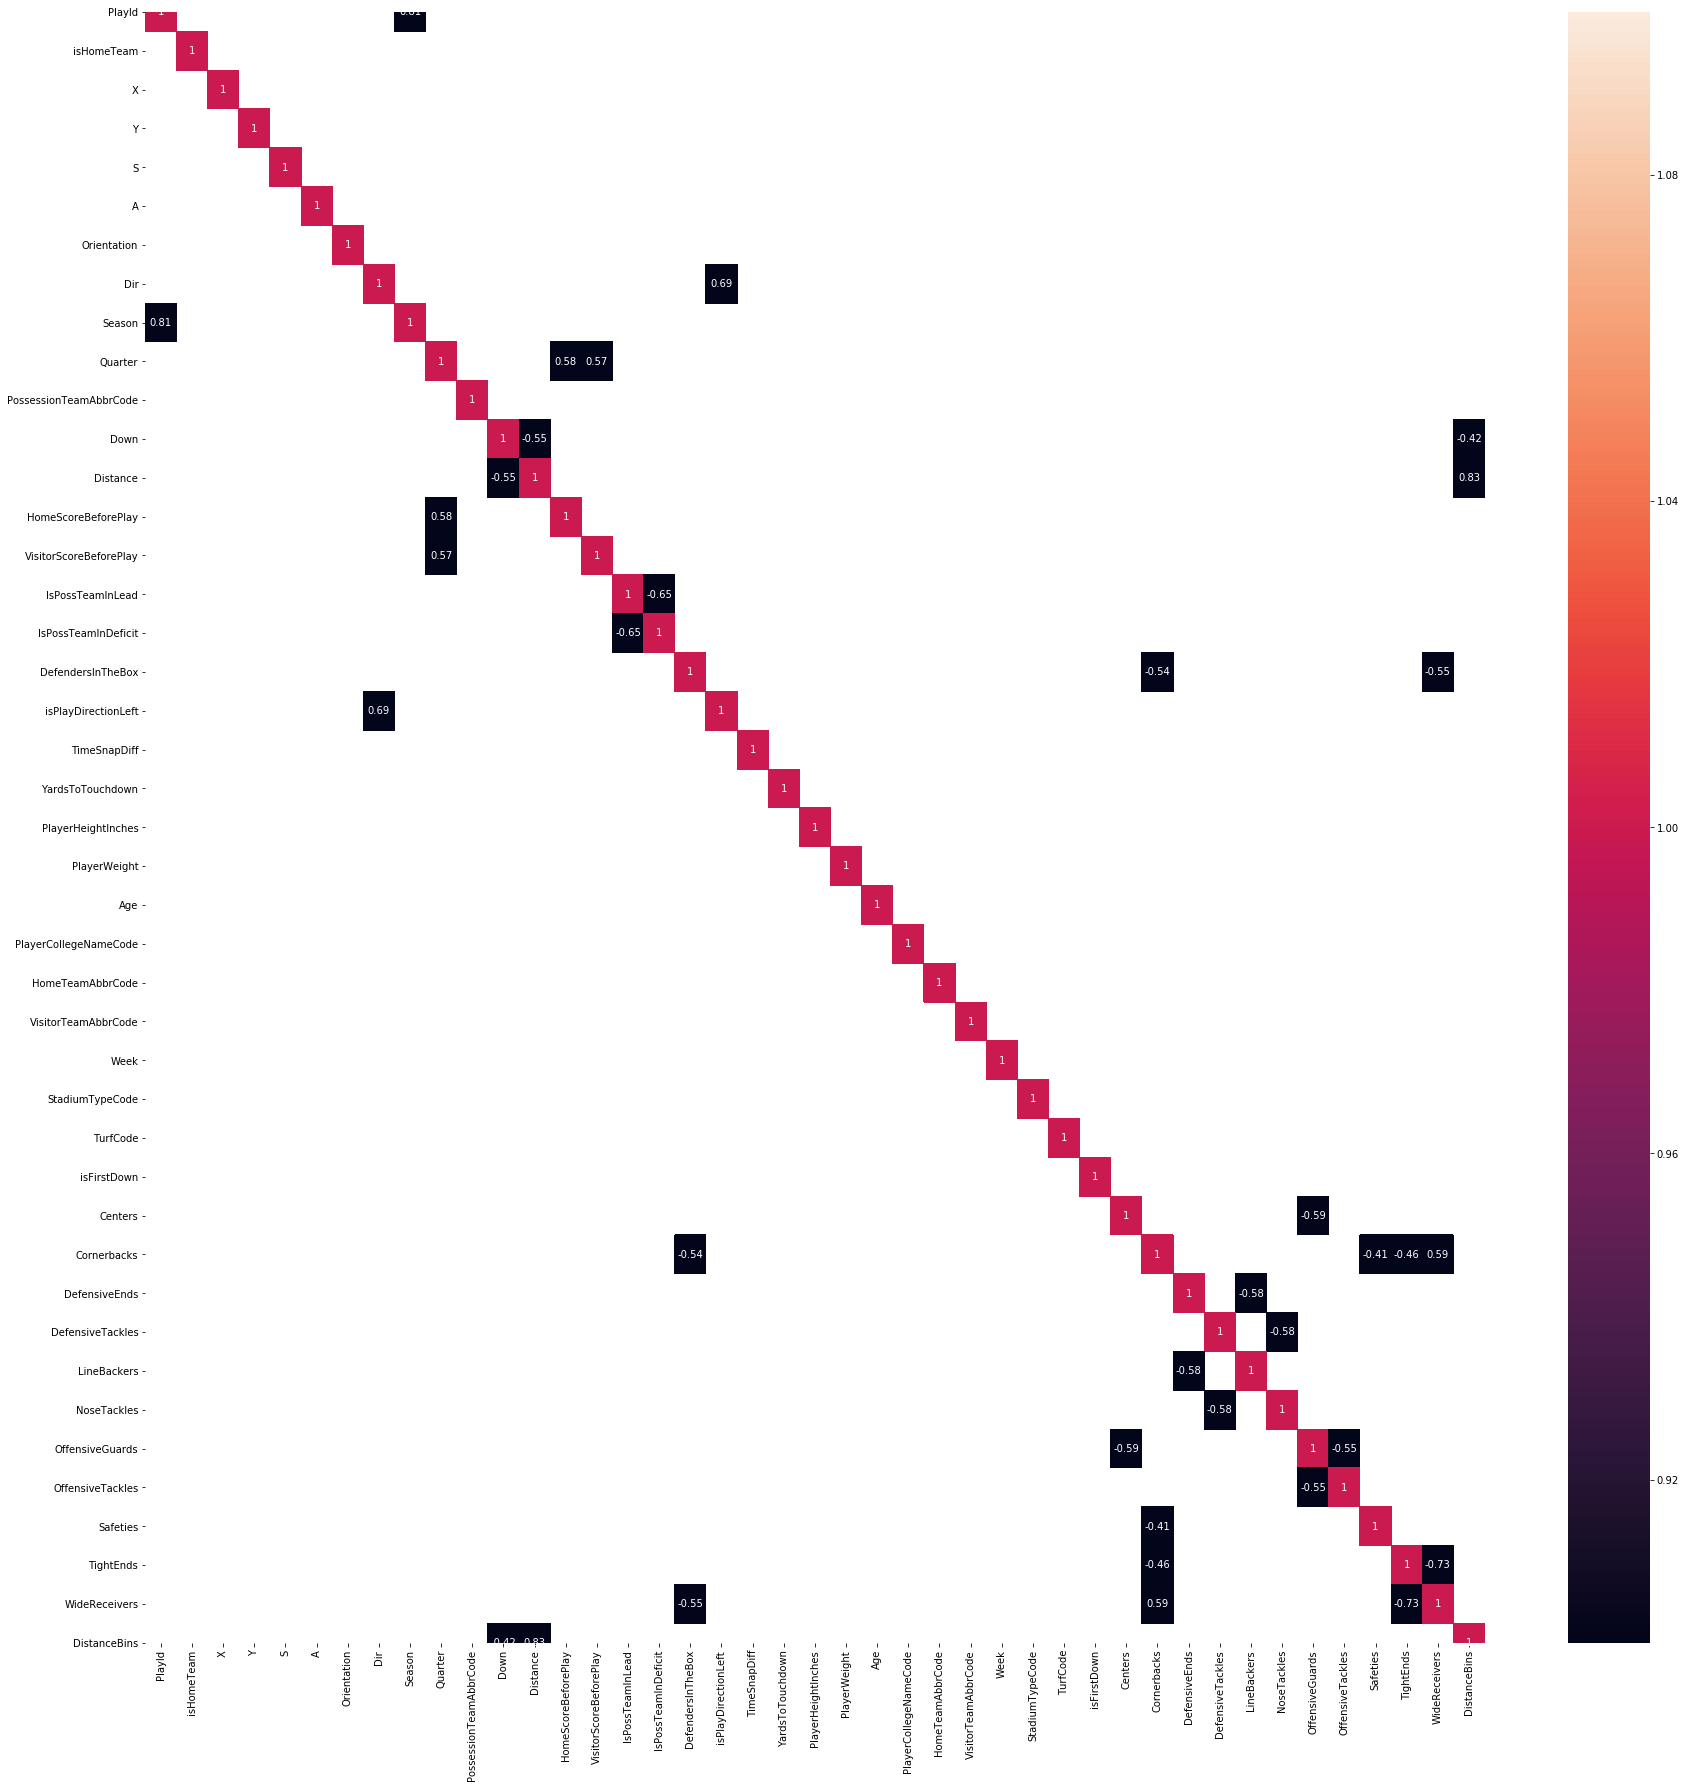

In [10]:
corrMatrix = df.corr(method = "kendall")
fig, ax = plt.subplots(figsize=(30,30)) 
# sns.heatmap(corrMatrix, annot=True)
sns.heatmap(corrMatrix[(corrMatrix>=0.5) | (corrMatrix<=-0.4)], vmax=1.0, vmin=1.0, annot=True)
plt.savefig("../reports/figures/data_corr_matrix.png")

## Checking Correlation between Lead and Deficiit

In [11]:
print(df[["IsPossTeamInLead","IsPossTeamInDeficit"]].corr())

                     IsPossTeamInLead  IsPossTeamInDeficit
IsPossTeamInLead             1.000000            -0.653294
IsPossTeamInDeficit         -0.653294             1.000000


In [12]:
df.drop(['IsPossTeamInDeficit'], axis=1, inplace=True)

In [13]:
df.dtypes

PlayId                      int64
isHomeTeam                  int64
X                         float64
Y                         float64
S                         float64
A                         float64
Orientation               float64
Dir                       float64
Season                      int64
Quarter                     int64
PossessionTeamAbbrCode      int64
Down                        int64
Distance                    int64
HomeScoreBeforePlay         int64
VisitorScoreBeforePlay      int64
IsPossTeamInLead            int64
DefendersInTheBox           int64
isPlayDirectionLeft         int64
TimeSnapDiff              float64
YardsToTouchdown            int64
PlayerHeightInches          int64
PlayerWeight                int64
Age                         int64
PlayerCollegeNameCode       int64
HomeTeamAbbrCode            int64
VisitorTeamAbbrCode         int64
Week                        int64
StadiumTypeCode             int64
TurfCode                    int64
isFirstDown   

In [14]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

In [15]:
to_drop

['Season', 'isPlayDirectionLeft', 'WideReceivers', 'DistanceBins']

In [16]:
print(df[["TightEnds","WideReceivers"]].corr())

               TightEnds  WideReceivers
TightEnds       1.000000      -0.758254
WideReceivers  -0.758254       1.000000


In [17]:
df.drop(['WideReceivers'], axis=1, inplace=True)

In [18]:
print(df[["OffensiveGuards","OffensiveTackles"]].corr())

                  OffensiveGuards  OffensiveTackles
OffensiveGuards          1.000000         -0.594713
OffensiveTackles        -0.594713          1.000000


In [19]:
df.drop(['OffensiveTackles'], axis=1, inplace=True)

In [20]:
df.shape

(28511, 40)

In [21]:
df.to_csv("../data/processed/data_bivariate.csv")

In [22]:
# from scipy.stats import describe
# describe(df, axis=0)
